In [19]:
import numpy as np 
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import cv2

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

Standardization = z-score normalization, 元データの平均を0に、標準偏差が1に変換する。


$
x_{new}^{i}=\frac{x^i-\mu}{\sigma}
$

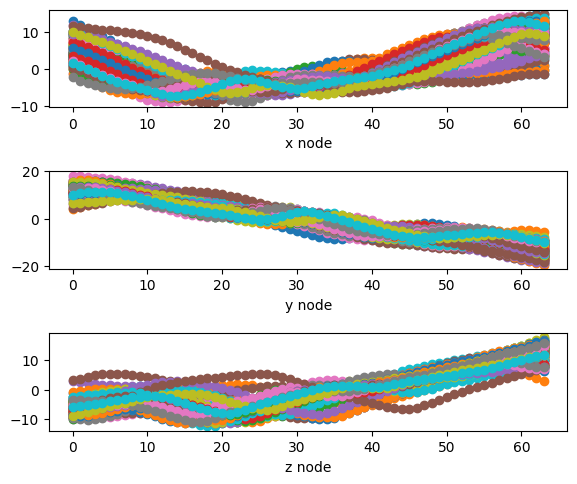

In [20]:
files = glob.glob("./scaling/resamp_attr_ascii/*.vtk")

#########################################
#    vmtkで計算したcurv, torsを使う      #
#       0.5mmまでresamplingした         # 
#########################################
# files = (glob.glob(".\\scaling\\resamp_attr_ascii\\vmtkgeometry\\*.vtk"))


r = []
pts = []
PTN = []
curvs = []
torss = []
abscs = [] 
for i in range(len(files)): 
    pt, Curv, Tors, Radius, Abscissas, ptns = GetMyVtk(files[i])
    if len(pt) != 64:
        print (len(pt), files[i])
        continue
    centroid = np.array([np.mean(pt[:,0]),np.mean(pt[:,1]),np.mean(pt[:,2])])
    pt = pt-centroid
    pts.append(pt)
    r.append(Radius)
    PTN.append(ptns)
    curvs.append(Curv)
    torss.append(Tors)
    abscs.append(Abscissas)
pts = np.array(pts)
r = np.array(r)
PTN = np.array(PTN)
curvs=np.array(curvs)
torss = np.array(torss)
abscs= np.array(abscs)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(pts[i])), pts[i,:,0])
    ax2.scatter(range(len(pts[i])), pts[i,:,1])
    ax3.scatter(range(len(pts[i])), pts[i,:,2])
plt.savefig("experiment_note/img/og_coord.png")

0
[1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0
 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0]


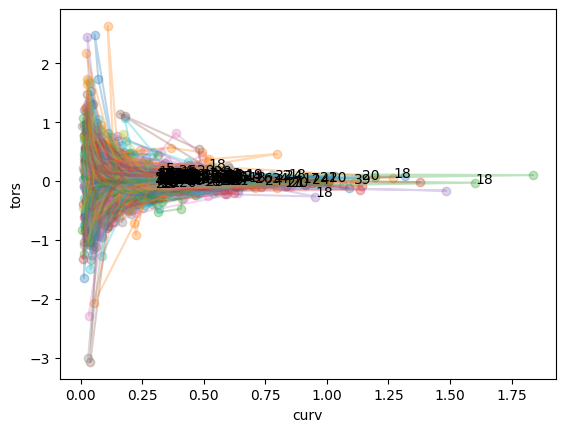

In [21]:
torsion_inverse = []

###################################################
#    torsion_inverse: [vessel_idx, node1, node2]  #
#    t_inverse:[0:non-inversed,                   #
#                1:inversed;                      #
#                location:idx]                    #
###################################################

filtered = 0
for i in range(len(pts)): 
    #if max(curvs[i])<1.0 and max(abs(torss[i]))<1.0:
    if 1:
        plt.scatter(curvs[i], torss[i], label="{:0=3}".format(i), alpha=0.3)
        plt.plot(curvs[i], torss[i], alpha=0.3)
        for j in range(1, len(curvs[i])-1 ):
            if curvs[i][j] > 0.3 :
                if torss[i][j]*torss[i][j+1]<0:
                    torsion_inverse.append([i, j, j+1])
                    plt.text(x=curvs[i][j], y=torss[i][j], s=j)
                elif torss[i][j-1]*torss[i][j]<0 and [i, j-1, j] not in torsion_inverse:
                    torsion_inverse.append([i, j-1, j])
                    plt.text(x=curvs[i][j], y=torss[i][j], s=j)
    else:
        filtered+=1

print (filtered)

torsion_inverse = np.array(torsion_inverse)
plt.xlabel("curv")
plt.ylabel("tors")
# plt.title("PC2")
# plt.legend()

# print (torsion_inverse)

################################################
#         分成有inverse和无inverse　　　　　　　 #
################################################

t_inverse = np.zeros_like(range(len(files)))
# print (torsion_inverse[:,0])

t_inverse[torsion_inverse[:,0]]=1
print (t_inverse)

## 参照文献[1]的方法计算Ec和Et

[1] Objective characterization of the course of the parasellar internal carotid artery using mathematical tools

- 计算出的值和文献给出的差异很大

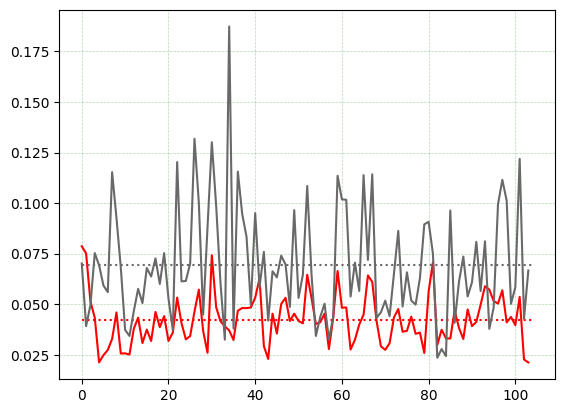

In [22]:
def Energy_curvtors(curv, pt):
    # c_length = measure_length(pts)*measure_length(pts)
    c_length = 1
    c_sum = 0
    for i in range(len(curv)):
        c_sum+=min(1, (curv[i])*(curv[i]))
    # print (c_sum/len(curv))
    return c_length*(c_sum/len(curv))

curv_energe = []
tors_energe = []
for i in range(len(files)):
    curv_energe.append(Energy_curvtors(curvs[i][2:-2], pts[i][2:-2]))
    tors_energe.append(Energy_curvtors(torss[i][2:-2], pts[i][2:-2]))

plt.plot(curv_energe, color="red")
plt.plot([0,104],[np.mean(curv_energe), np.mean(curv_energe)], color="red", linestyle=":")
plt.plot(tors_energe,color="dimgray")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.plot([0,104],[np.mean(tors_energe), np.mean(tors_energe)], color="dimgray", linestyle=":")

In [23]:
from scipy.spatial.transform import Rotation
# from skopt import gp_minimize
from scipy.optimize import minimize

print (Rotation.random().as_matrix().shape)

curve = pts[16]

def distance_curve2yz(curve):
    d = 0
    for i in range(len(curve)):
        # p_on_yx = (0, curve[i][1],curve[i][2])
        d = d + abs(curve[i,0])
    return d


def rotate_curve(curve, quat):
    rot = Rotation.from_quat(quat)
    return (rot.apply(curve))

def opt_distance(quat):
    c = curve
    return distance_curve2yz(rotate_curve(c, quat))

res = minimize(opt_distance, x0=Rotation.random().as_quat(), method='Nelder-Mead')
print (res.x)
#print (res)

new_curve = rotate_curve(curve, res.x)

(3, 3)
[-0.34499294 -0.04448208  0.26165388  0.27521686]


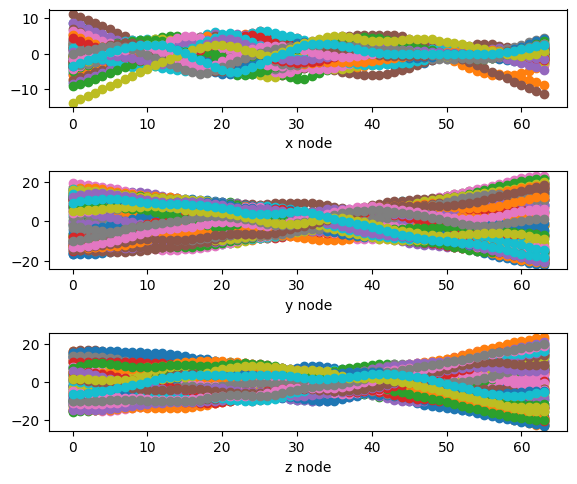

In [24]:
new_pts = []

for i in range(len(pts)):
    curve = pts[i]
    res = minimize(opt_distance, x0=Rotation.random().as_quat(), method='Nelder-Mead')
    # print (res.x)
    #print (res)
    new_curve = rotate_curve(curve, res.x)
    new_pts.append(new_curve)

new_pts = np.array(new_pts)


fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(new_pts[i])), new_pts[i,:,0])
    ax2.scatter(range(len(new_pts[i])), new_pts[i,:,1])
    ax3.scatter(range(len(new_pts[i])), new_pts[i,:,2])
plt.savefig("experiment_note/img/rot_coord.png")

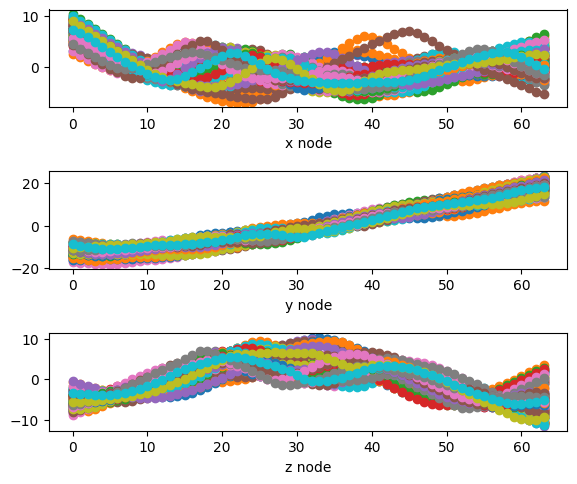

In [25]:
from procrustes import rotational

v1 = 0
v2 = 0
aligned_pts = []
aligned_pts.append(new_pts[0,:,:])
for i in range(1, len(new_pts)):
    result_rot = rotational(new_pts[i,:,:], new_pts[0,:,:], translate=False, scale=False)
    # aligned_pts.append(result_rot.new_a)
    aligned_pts.append(np.dot(result_rot.new_a, result_rot.t))
    scalarAttribute= [['MaximumInscribedSphereRadius', 'float', r[i]]]
    # makeVtkFile(savePath = "D:\\!BraVa_src\\src\\ModeDecomposition\\rot_alignment\\"+files[i].split("\\")[-1],
    #             coords = np.dot(result_rot.new_a, result_rot.t),
    #             scalarAttributes=scalarAttribute,
    #             fieldAttributes=[] )



aligned_pts = np.array(aligned_pts)

# fig = plt.figure(figsize=(6, 5))
# ax = fig.add_subplot(111, projection='3d')
# for i in range(100):
#     ax.plot(aligned_pts[i,:,0], aligned_pts[i,:,1], aligned_pts[i,:,2])
# ax.view_init(v1, v2)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,0])
    ax2.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,1])
    ax3.scatter(range(len(aligned_pts[i])), aligned_pts[i,:,2])
plt.savefig("experiment_note/img/procrustes_coord.png")

## 经过paraview输出确认（.\\rotated_cluster\\）旋转后方向一致
color represents node idx, not Radius

![](./experiment_note/alignedPts.png)

In [26]:
from datetime import datetime
import time
SAVE_ALIGNED_PTS = 0

if SAVE_ALIGNED_PTS == 1:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        np.save(file=".\\centroid_aligned_pts_{}.npy".format(time_str),
                arr=aligned_pts)

(64,)


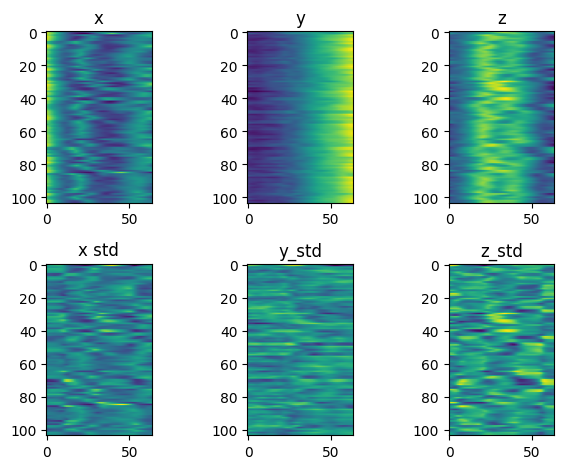

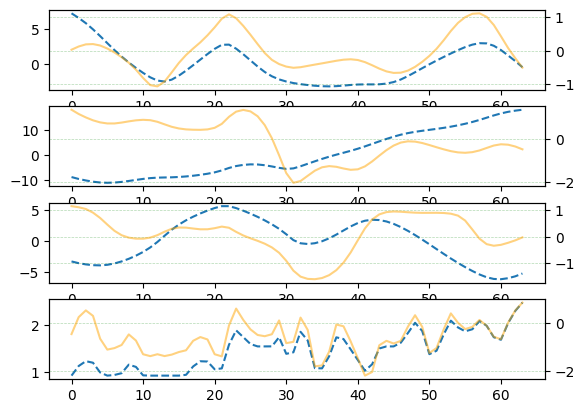

In [27]:
# 標準化

x = aligned_pts[:,:,0]
y = aligned_pts[:,:,1]
z = aligned_pts[:,:,2]

X_std = zscore(x,axis=0)
Y_std = zscore(y,axis=0)
Z_std = zscore(z,axis=0)
R_std = zscore(r,axis=0)

x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)

y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)

z_mean = np.mean(z, axis=0)
z_std = np.std(z, axis=0)

r_mean = np.mean(r, axis=0)
r_std = np.std(r, axis=0)

print (x_std.shape)

fig = plt.figure()
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(x)
ax2.imshow(y)
ax3.imshow(z)
ax4.imshow(X_std)
ax5.imshow(Y_std)
ax6.imshow(Z_std)

ax1.set_title("x")
ax2.set_title("y")
ax3.set_title("z")
ax4.set_title("x std")
ax5.set_title("y_std")
ax6.set_title("z_std")
plt.tight_layout()

# quad_std = np.append(X_std, np.append(Y_std,np.append(Z_std,R_std,axis=1),axis=1),axis=1)
quad_std = np.append(X_std, np.append(Y_std,Z_std,axis=1),axis=1)
# quad_std = np.append(X_std,Z_std,axis=1)
# print (quad_std.shape)



i=99

fig = plt.figure()
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.plot(range(len(aligned_pts[i])), aligned_pts[i][:,0],linestyle="--")
ax1 = ax1.twinx()
ax1.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax1.plot(range(len(X_std[i])), X_std[i],alpha=0.5, color="orange")
ax2.plot(range(len(aligned_pts[i])), aligned_pts[i][:,1],linestyle="--")
ax2 = ax2.twinx()
ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax2.plot(range(len(Y_std[i])), Y_std[i],alpha=0.5, color="orange")
ax3.plot(range(len(aligned_pts[i])), aligned_pts[i][:,2],linestyle="--")
ax3 = ax3.twinx()
ax3.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax3.plot(range(len(Z_std[i])), Z_std[i],alpha=0.5, color="orange")
ax4.plot(range(len(r[i])), r[i],linestyle="--")
ax4 = ax4.twinx()
ax4.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
ax4.plot(range(len(R_std[i])), R_std[i],alpha=0.5, color="orange")

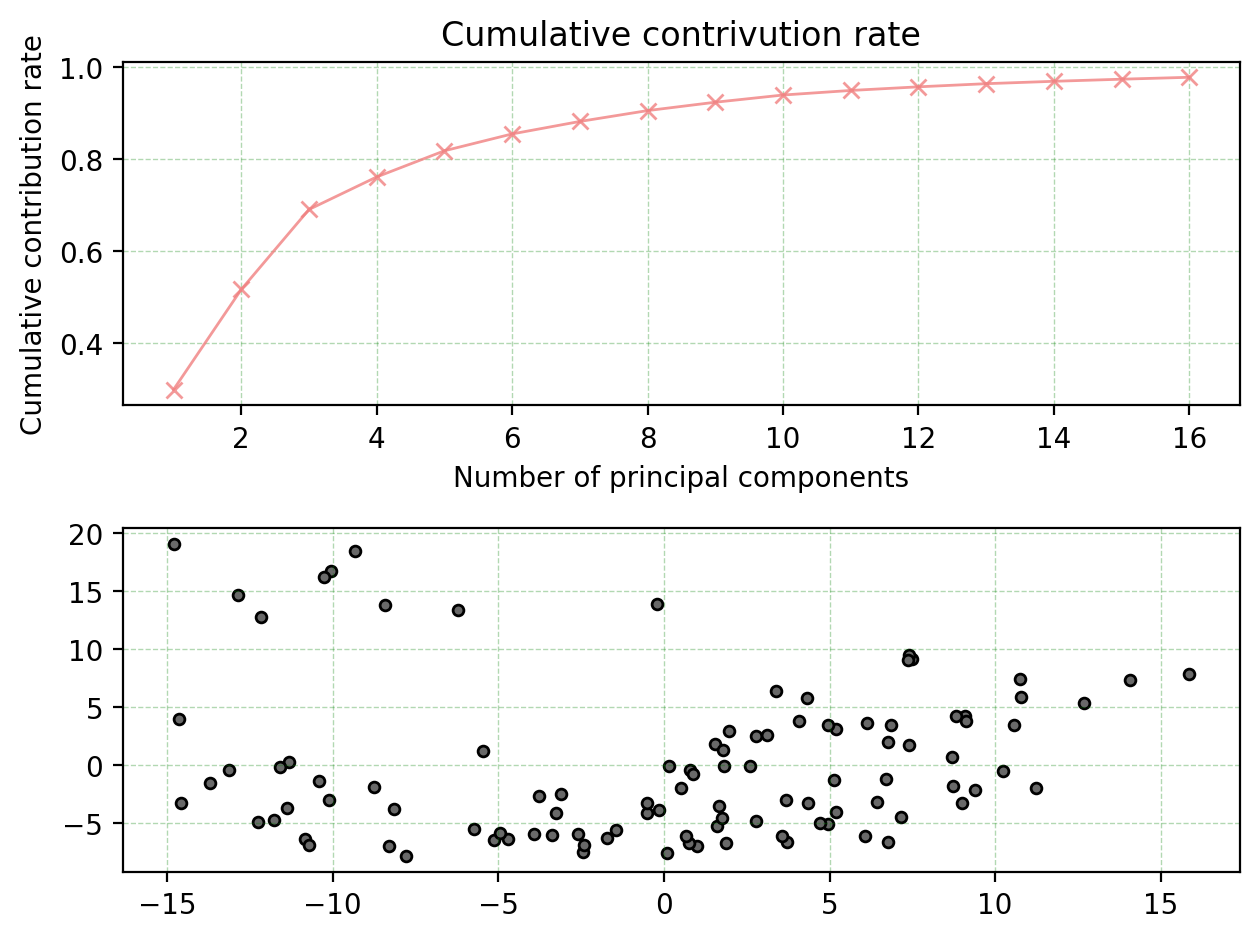

In [28]:
from sklearn.decomposition import PCA

CROSS_VALID = 0

fig = plt.figure(dpi=200)
ax = fig.add_subplot(211)
pca = PCA(n_components=16)
result = pca.fit_transform(quad_std)
cumsum = list(np.cumsum(pca.explained_variance_ratio_))
ax.plot(range(1, len(cumsum)+1),cumsum, "-x",alpha=0.8, linewidth=1, color='lightcoral')
#ax.set_xticks([])
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative contribution rate")
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
ax.set_title("Cumulative contrivution rate")
ax.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)

ax2 = fig.add_subplot(212)

ax2.scatter(result[:,0],result[:,1],
            color = "dimgray", 
            alpha=1, 
            edgecolors="black", 
            linewidths=1, s=15)
ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)

plt.tight_layout()

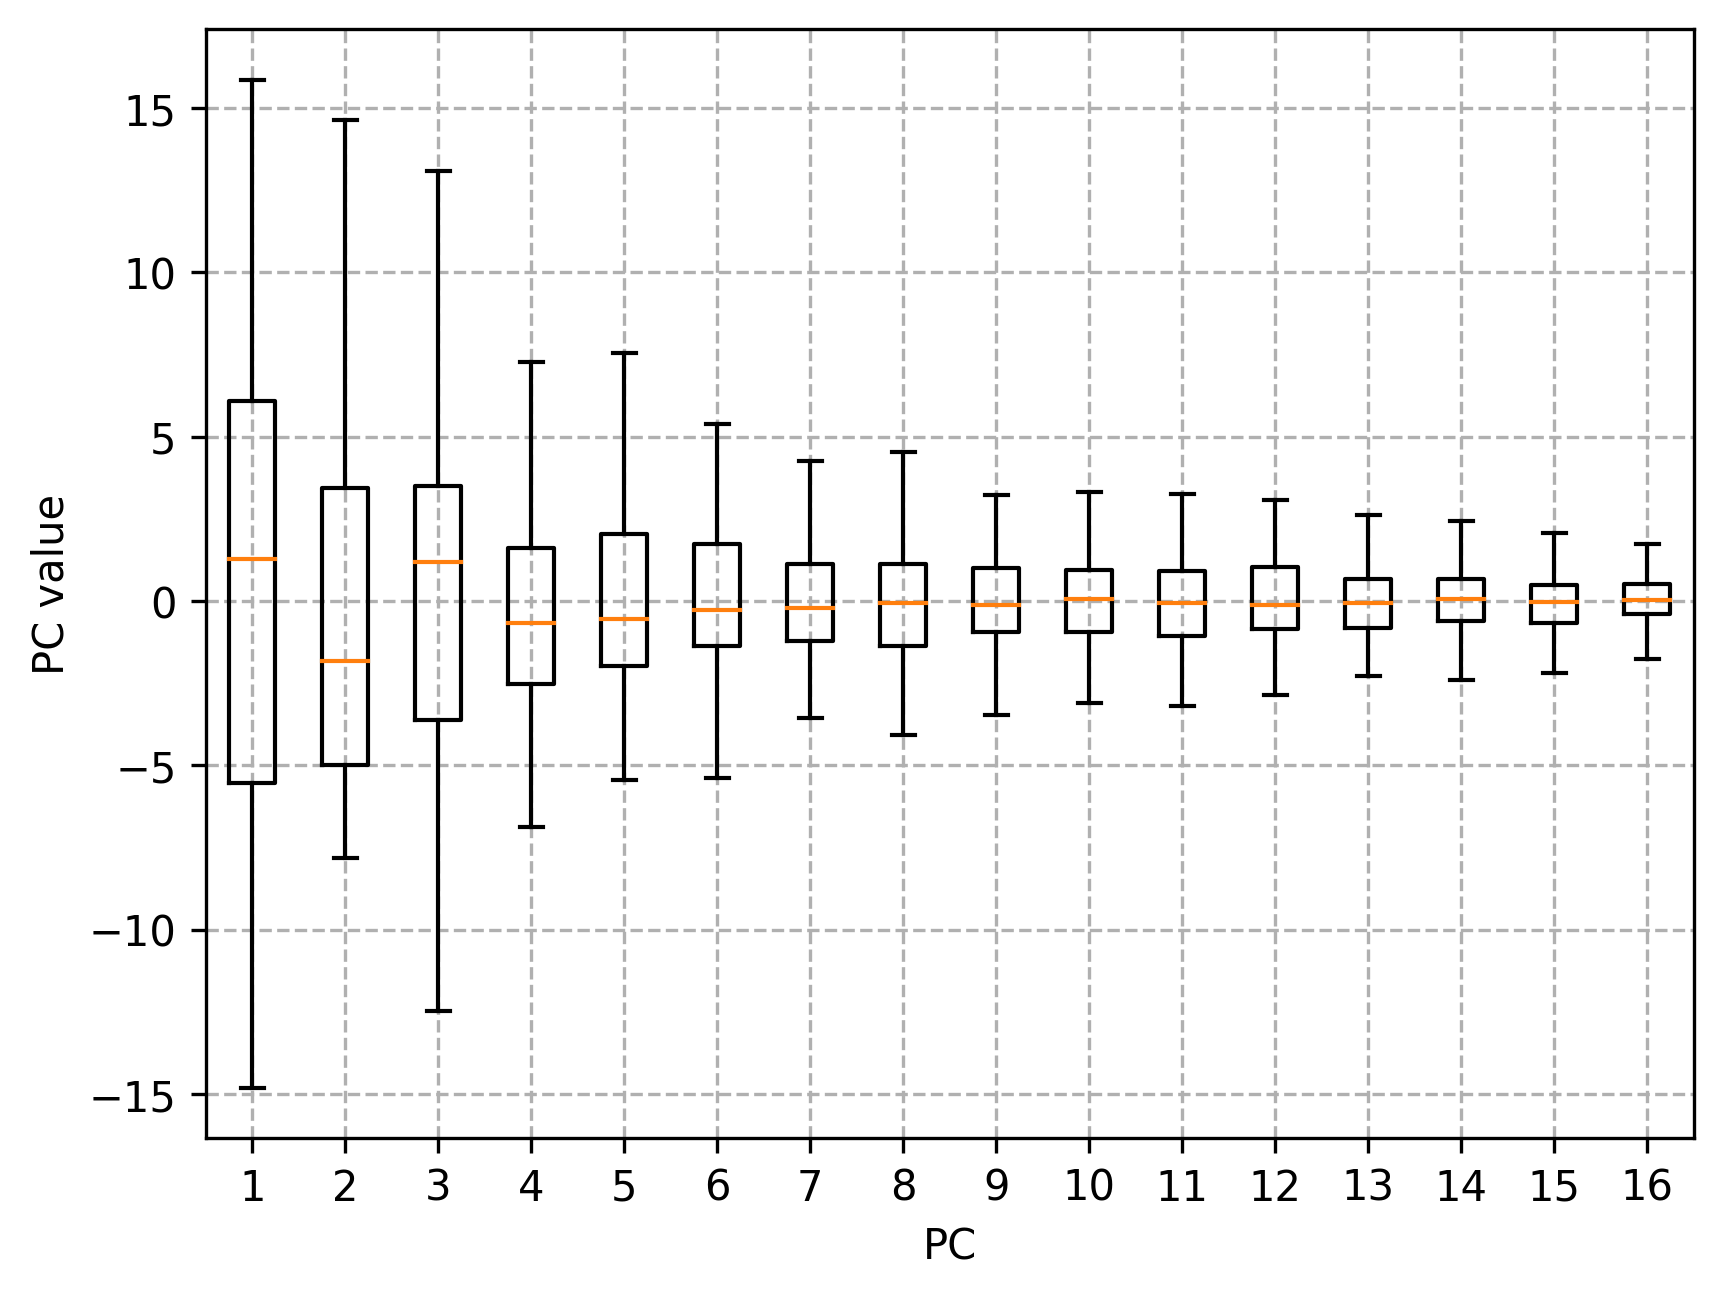

In [29]:

fig = plt.figure(dpi=300)
ax =fig.add_subplot(111)

ax.boxplot(result,showfliers=False)

ax.set_xlabel("PC")
ax.set_ylabel("PC value")
plt.grid(linestyle="--")
plt.show()

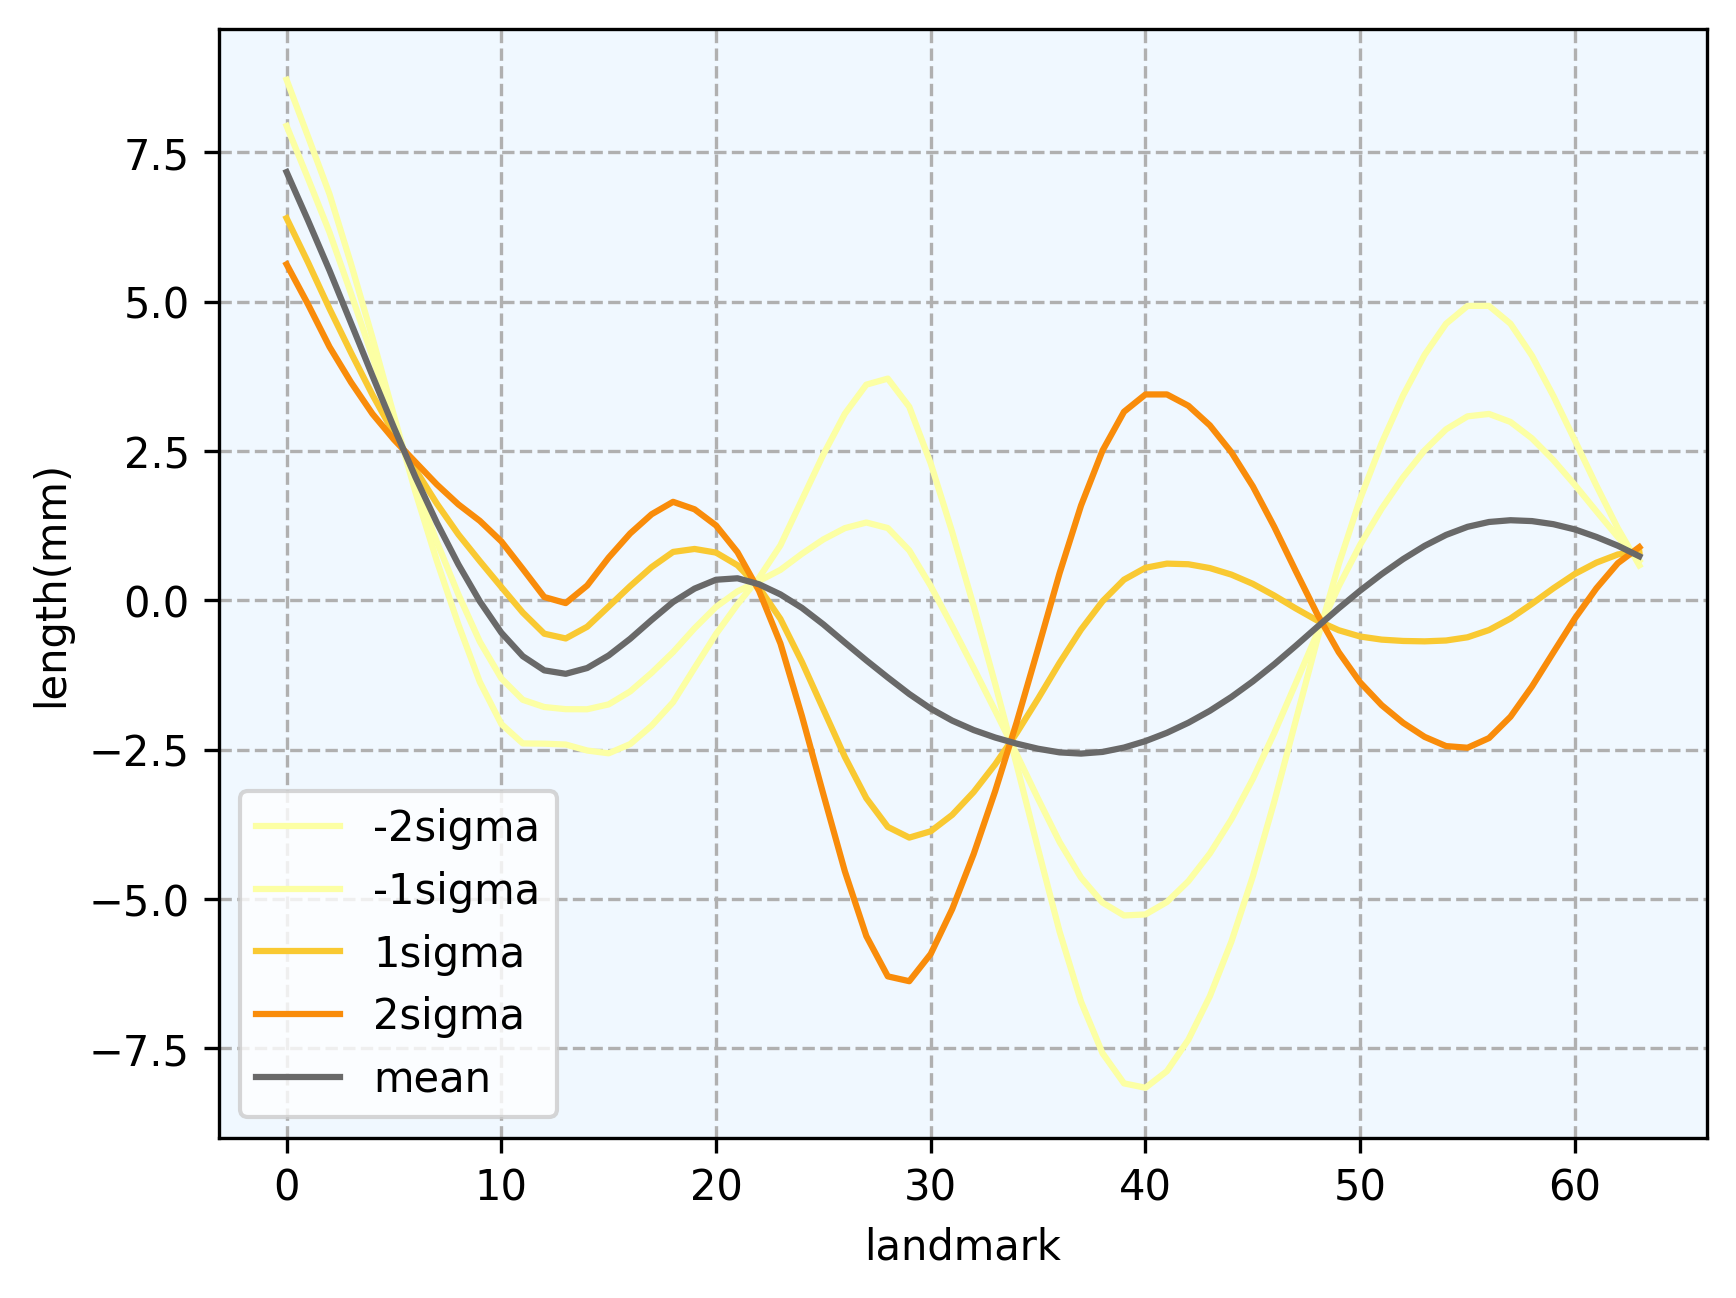

In [30]:
import matplotlib
def inverse(feature):
    feature = np.array(feature)
    # print(feature)
    resultinverse = pca.inverse_transform(feature)
    # result: (192,)
    shape = np.zeros(resultinverse.shape[0]).reshape(resultinverse.shape[0]//3, 3)
    shape[:,0] =resultinverse[:64]
    shape[:,1] =resultinverse[64:128]
    shape[:,2] =resultinverse[128:]
    return shape

def inverse_recover(shape):
    # print (np.std(aligned_pts,axis=0).shape)
    # print (np.mean(aligned_pts,axis=0).shape)
    recover_shape = shape*np.std(aligned_pts,axis=0)+np.mean(aligned_pts,axis=0)
    return recover_shape


cmap = matplotlib.cm.get_cmap("inferno_r")
fig = plt.figure(dpi=300)
ax =fig.add_subplot(111)

pcs_std = []
pcs_mean  = []
for i in range(len(pca.components_)):
    pcs_std.append(np.std(result[:,i]))
    pcs_mean.append(np.mean(result[:,i]))

pcs_mean = np.array(pcs_mean)  
pcs_std = np.array(pcs_std)
# print (pcs_std.shape,pcs_mean)



mean_shape = inverse_recover((inverse(pcs_mean)))
np.save("./landmark_meanshape.npy",mean_shape)
for j in range(len([-2,-1,1,2])):
    i = [-2,-1,1,2][j]
    std1_shape = inverse_recover(inverse(pcs_mean+i*pcs_std))
    ax.plot(std1_shape[:,0],label="{}sigma".format(i), color=cmap(i/8))

ax.plot(mean_shape[:,0],label="mean",color="dimgray")

ax.set_xlabel("landmark")
ax.set_ylabel("length(mm)")
ax.set_facecolor("aliceblue")

plt.legend()
plt.grid(linestyle="--")
plt.show()

### PC1支配了什么？？？
在y=0的线附近取点看

In [31]:
synthetic = np.zeros_like((result[:10,:]))
print (synthetic.shape[1])
for i in range(synthetic.shape[1]):
    synthetic[i][0] = i-4
print (synthetic)

syn = pca.inverse_transform(synthetic)
# print (syn.shape)

colorpalette=np.array(sns.color_palette(palette="Reds_r", n_colors=syn.shape[0]))
colordict = {}
for i in range(syn.shape[0]):
    colordict[i]=colorpalette[i]

#print (quad_std.shape)
for i in range(syn.shape[0]):
    if i != 0:
        plt.scatter(range(len(syn[i])), syn[i],color = colordict[i],s =2)
    else :
        plt.scatter(range(len(syn[i])), syn[i],color = colordict[i],s =2)

plt.scatter(range(len(syn[i])), pca.mean_,color="black",s =2)

16


IndexError: index 10 is out of bounds for axis 0 with size 10

C:\Users\cheno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


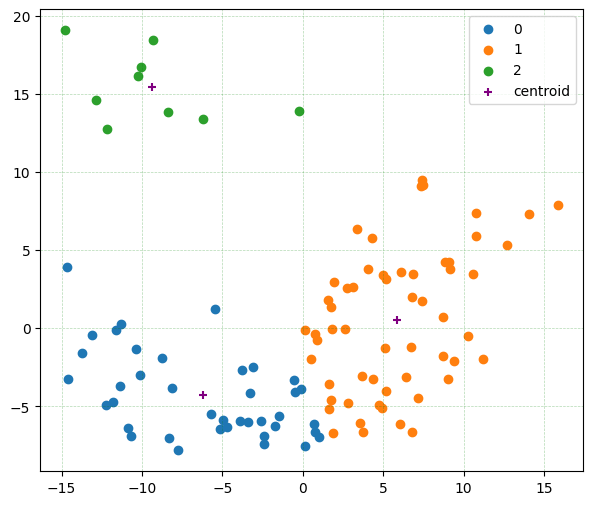

In [34]:
from sklearn.cluster import KMeans
from scipy import optimize
from math import sqrt


#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(result)
 
#Getting unique labels
u_labels = np.unique(label)

# display (label)
# display (u_labels)

#plotting the results:
plt.figure(figsize=(7,6))
for i in u_labels:
    plt.scatter(result[label == i , 0] , result[label == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.legend()
# plt.savefig('cluster.png')
plt.show()

# 在z上单调增加，且PC浮动小

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


ValueError: shapes (10,) and (16,192) not aligned: 10 (dim 0) != 16 (dim 0)

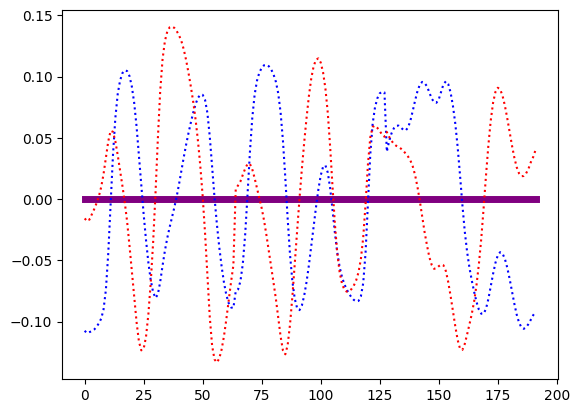

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(pca.mean_, color = "purple", linewidth=5, label="mean")

ax.plot(pca.components_[0], color = "blue", linestyle=":", label="PC1")
# ax.plot(pca.inverse_transform(pca.components_[0]))
ax.plot(pca.components_[1], color = "red", linestyle=":", label="PC2")
# ax.plot(pca.mean_, color= "dimgray")


# 一个“一倍PC1"形状
temp = np.zeros((10))
temp[0] = 1
print (temp)
ax.plot(pca.inverse_transform(temp), label="PC1x +1")
temp[0] = -1
ax.plot(pca.inverse_transform(temp), label="PC1x -1")

#ax.bar(96,bottom = -2, height = 4, width=64,alpha=0.3, color="dimgray")

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.legend()

# 移除Y, Z轴后pca降维结果微变，kmeans clustering结果没变

C:\Users\cheno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


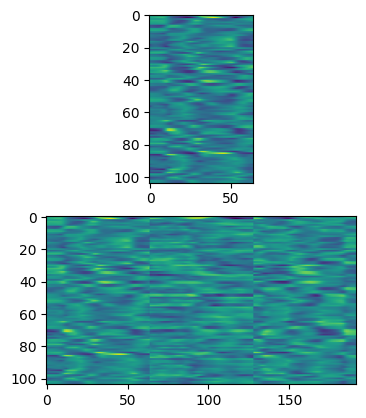

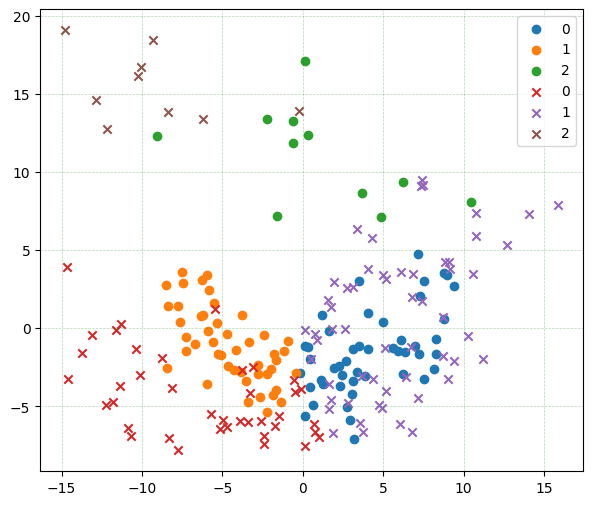

In [35]:
# tw_std  = np.append(quad_std[:,:64],quad_std[:,128:],axis=1)
# tw_std = quad_std[:,:128]
tw_std = quad_std[:,:64]

fig = plt.figure()
ax1= fig.add_subplot(211)
ax1.imshow(tw_std)
ax2 = fig.add_subplot(212)
ax2.imshow(quad_std)


tw_pca = PCA(n_components=10)

tw_result = tw_pca.fit_transform(tw_std)


#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
tw_label = kmeans.fit_predict(tw_result)
 
#Getting unique labels
tw_u_labels = np.unique(tw_label)

# display (label)
# display (u_labels)

#plotting the results:
plt.figure(figsize=(7,6))
for i in tw_u_labels:
    plt.scatter(tw_result[tw_label == i , 0] , tw_result[tw_label == i , 1] , label = i)
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')

for i in u_labels:
    plt.scatter(result[label == i , 0] , result[label == i , 1] , label = i , marker="x")
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.legend()
plt.savefig("experiment_note/img/tw_vs_tri.png")
plt.show()

# torsion是否反转未被检出

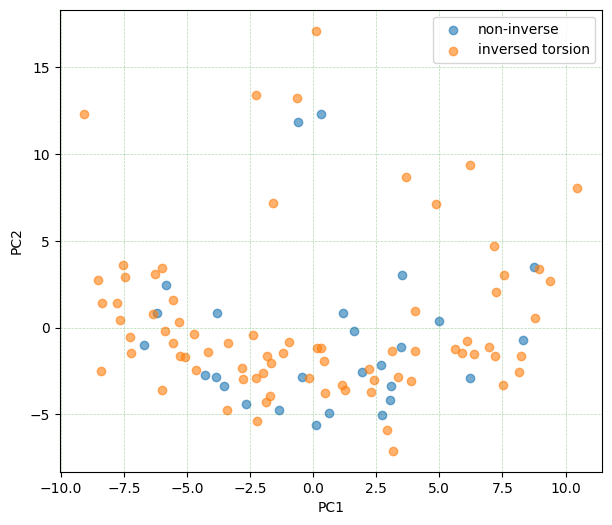

In [37]:
plt.figure(figsize=(7,6))
for i in [0,1]: # t_inverse
    if i == 0:
        lbl = "non-inverse"
    else:
        lbl = "inversed torsion"
    plt.scatter(tw_result[t_inverse == i , 0] , tw_result[t_inverse == i , 1] , label = lbl, alpha=0.6)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.show()


## 求Synthetic vessel的形状参数

### 在圆周上按角度取点（需要先拟合圆周）
### 固定其他PC，取极值(需要boxplot)
- 这个方法的一个潜在问题是**复原出来的间隔可能完全不是1mm**
    - 可能的关键字：elastic

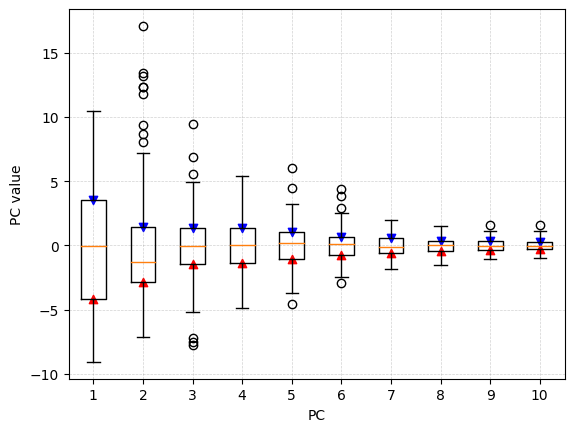

In [38]:
ax = plt.boxplot(tw_result)
plt.xlabel("PC")
plt.ylabel("PC value")
q1s=[]
q3s=[]

for i in range(tw_result.shape[1]):
    plt.scatter(i+1,np.quantile(a=tw_result[:,i],q=0.25),marker="^", color="red")
    plt.scatter(i+1,np.quantile(a=tw_result[:,i],q=0.75),marker="v", color="blue")
    q1s.append(np.quantile(a=tw_result[:,i],q=0.25))
    q3s.append(np.quantile(a=tw_result[:,i],q=0.75))
plt.grid(color = 'dimgray', linestyle = '--', linewidth = 0.5,alpha=0.3)
plt.savefig("experiment_note/img/boxplot.png")

In [39]:
import numpy as np


def square_root_velocity(trajectory):
    velocity = np.diff(trajectory, axis=0)
    velocity_magnitude =np.linalg.norm(velocity, axis=-1)
    for i in range(len(velocity)):
        # print (velocity[i])
        velocity[i,0]=velocity[i,0]/velocity_magnitude[i]
        velocity[i,1]=velocity[i,1]/velocity_magnitude[i]
        velocity[i,2]=velocity[i,2]/velocity_magnitude[i]
    return velocity

sr = []
for i in range(len(aligned_pts)):
    sr_velocity = square_root_velocity(aligned_pts[i])
    sr.append(sr_velocity)

sr = np.array(sr)

sr.shape
X_std = zscore(sr[:,:,0],axis=0)
Y_std = zscore(sr[:,:,1],axis=0)
Z_std = zscore(sr[:,:,2],axis=0)


# quad_std = np.append(X_std, np.append(Y_std,np.append(Z_std,R_std,axis=1),axis=1),axis=1)
trio_std = np.append(X_std, np.append(Y_std,Z_std,axis=1),axis=1)
# quad_std = np.append(X_std,Z_std,axis=1)
print (trio_std.shape)
print ("trio_std: sr")
from sklearn.manifold import LocallyLinearEmbedding

# 设置Tangent PCA参数
n_neighbors = 65

n_components = 2

# 应用Tangent PCA进行降维
tangent_pca = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='ltsa')
X_tangent_pca = tangent_pca.fit_transform(trio_std)




(104, 189)
trio_std: sr


C:\Users\cheno\AppData\Local\Temp\ipykernel_12460\3040782245.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


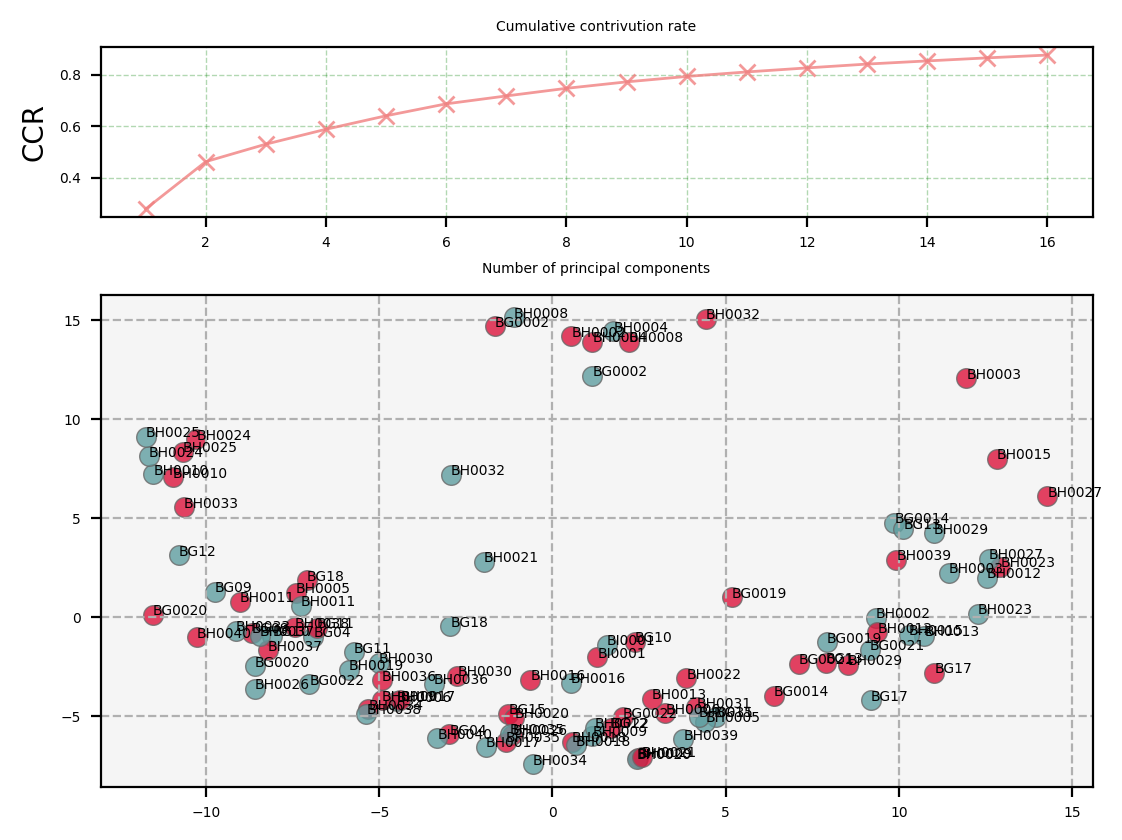

In [40]:
fig = plt.figure(dpi=200)
gs1 = fig.add_gridspec(nrows=30, ncols=20)
ax0 = fig.add_subplot(gs1[0:7, :])
ax = fig.add_subplot(gs1[10:, :])
for a in [ax0, ax]:
    a.tick_params(axis='both', which='major', labelsize=5)
    a.tick_params(axis='both', which='minor', labelsize=4) 

pca = PCA(n_components=16)
feature = pca.fit_transform(trio_std)
reconstructed = pca.inverse_transform(feature)
cumsum = list(np.cumsum(pca.explained_variance_ratio_))

ax0.plot(range(1, len(cumsum)+1),cumsum, "-x",alpha=0.8, linewidth=1, color='lightcoral')
#ax.set_xticks([])
ax0.set_xlabel("Number of principal components", fontsize=5)
ax0.set_ylabel("CCR") # ("Cumulative contribution rate")
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
ax0.set_title("Cumulative contrivution rate", fontsize=5)
ax0.grid(color = 'green', linestyle = '--', linewidth = 0.5,alpha=0.3)


for i in range(len(files)):
    position = files[i].split("\\")[-1][:-4].split("_")[-1]
    if position =="Left":
        scatter_color="crimson"
    else:
        scatter_color="cadetblue"
    ax.scatter(feature[i,0], feature[i,1],
            s = 50,
            color = scatter_color,
            edgecolor="dimgray",
            linewidths=0.5,
            alpha=0.8)

    ax.text(feature[i,0], feature[i,1],
            files[i].split("\\")[-1][:-4].split("_")[0],
            fontsize=5)
ax.set_facecolor("whitesmoke")
ax.grid(linestyle="--")
plt.tight_layout()

(81, 63, 3)
(81, 189)
mean and std of extracted_trio_pts: (189,) (189,)


C:\Users\cheno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


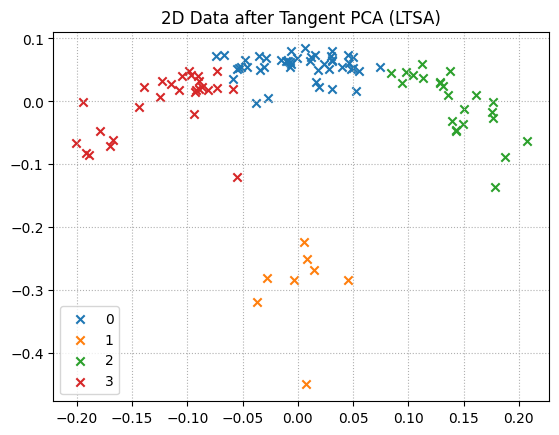

In [41]:



# Initialize the class object
kmeans = KMeans(n_clusters= 4)
#predict the labels of clusters.
label = kmeans.fit_predict(X_tangent_pca)
#Getting unique labels
u_labels = np.unique(label)


fig = plt.figure()
ax = fig.add_subplot(111)
# plt.scatter(X_tangent_pca[:, 0], X_tangent_pca[:, 1])
for i in  u_labels:
    ax.scatter(X_tangent_pca[label == i , 0] , X_tangent_pca[label == i , 1] , label = i , marker="x")


extracted_files = []
extracted_pts = []
extracted_sr = []
extracted_mask = np.zeros(len(files))
for j in range(len(files)):
    if label[j] != 2:
        extracted_files.append(files[j])
        extracted_pts.append(aligned_pts[j])
        extracted_sr.append(sr[j])
        extracted_mask[j] = 1.0

extracted_pts = np.array(extracted_pts)
extracted_sr = np.array(extracted_sr)
print (extracted_sr.shape)
extracted_trio_sr = np.append(extracted_sr[:,:,0], 
                              np.append(extracted_sr[:,:,1], 
                                        extracted_sr[:,:,2],axis=1),axis=1)

print (extracted_trio_sr.shape)


# # 计算原始数据的均值和标准差
mean = np.mean(extracted_trio_sr, axis=0)
std = np.std(extracted_trio_sr, axis=0)

print ("mean and std of extracted_trio_pts:",mean.shape, std.shape)


# # 使用scipy的zscore函数进行标准化处理
# extracted_trio_pts = zscore(extracted_trio_pts, axis=0)

# # coef = np.polyfit(X_tangent_pca[:,0], X_tangent_pca[:,1], 3)
# # y_fit = np.polyval(coef, X_tangent_pca[:,0])
# # y = X_tangent_pca[:,1]
# # ax.scatter(X_tangent_pca[:,0], y_fit, alpha=0.5)

ax.set_title('2D Data after Tangent PCA (LTSA)')
plt.legend()
plt.grid(linestyle=":")

每次运行时都要检测ulabel！！！！！

# 

In [42]:
for i in u_labels:
    print ("cluster:", i)
    for j in range(len(files)):
        if label[j] == i:
            print (files[j].split("\\")[-1].split("_")[0], 
                   files[j].split("\\")[-1].split("_")[1][:-4])

cluster: 0
BG0014 Left
BG0019 Left
BG0022 Left
BG04 Left
BG10 Left
BG12 Left
BG15 Left
BG15 Right
BG18 Right
BH0005 Right
BH0006 Left
BH0006 Right
BH0009 Left
BH0009 Right
BH0013 Left
BH0016 Left
BH0016 Right
BH0017 Left
BH0017 Right
BH0018 Left
BH0018 Right
BH0019 Left
BH0019 Right
BH0020 Left
BH0020 Right
BH0021 Left
BH0021 Right
BH0022 Left
BH0022 Right
BH0026 Left
BH0030 Left
BH0030 Right
BH0031 Left
BH0031 Right
BH0034 Left
BH0034 Right
BH0035 Left
BH0035 Right
BH0036 Left
BH0036 Right
BH0038 Right
BH0039 Right
BH0040 Right
BI0001 Left
BI0001 Right
cluster: 1
BG0002 Left
BG0002 Right
BH0002 Left
BH0004 Left
BH0004 Right
BH0008 Left
BH0008 Right
BH0032 Left
cluster: 2
BG0014 Right
BG0019 Right
BG0021 Left
BG0021 Right
BG13 Left
BG13 Right
BG17 Left
BG17 Right
BH0002 Right
BH0003 Left
BH0003 Right
BH0012 Left
BH0012 Right
BH0013 Right
BH0015 Left
BH0015 Right
BH0023 Left
BH0023 Right
BH0027 Left
BH0027 Right
BH0029 Left
BH0029 Right
BH0039 Left
cluster: 3
BG0020 Left
BG0020 Right
BG

coef: [-2.03804329e+02 -1.84140981e+01  8.84569676e+00  2.63732595e-01
 -4.30064292e-02]
reconstruction_error: 0.27908602504716634


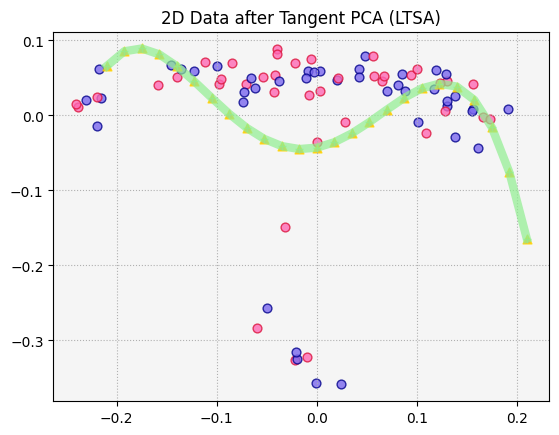

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)



# 设置Tangent PCA参数
n_neighbors = 60
n_components = 2

# 应用Tangent PCA进行降维
tangent_pca = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='ltsa')
X_tangent_pca = tangent_pca.fit_transform(extracted_trio_sr)

for j in range(len(extracted_files)):
    color_l = "mediumslateblue"
    color_r = "hotpink"
    edgec_l = "darkblue"
    edgec_r = "crimson"
    if "Right" in extracted_files[j]:
        color = color_r
        edgecolor = edgec_r
    else: 
        color = color_l
        edgecolor = edgec_l
    ax.scatter(X_tangent_pca[j , 0] , X_tangent_pca[j, 1] , 
            s = 40, marker="o" ,color= color, alpha=0.8,
            edgecolor=edgecolor,)
            # label="tangent PCA")

coef = np.polyfit(X_tangent_pca[:,0], X_tangent_pca[:,1], 4)
# y_fit = np.polyval(coef, X_tangent_pca[:,0])
x_test = np.linspace(-0.21, 0.21, 25)
y_fit = np.polyval(coef, x_test)
y = X_tangent_pca[:,1]
ax.plot(x_test, y_fit, alpha=0.7, color="lightgreen", marker="+", linewidth=6, label="quadratic fitting")

# for j in range(len(extracted_files)):
#     ax.text(X_tangent_pca[j , 0] , X_tangent_pca[j, 1] ,
#             '{}'.format(extracted_files[j].split("\\")[-1][:-4]))
ax.set_title('2D Data after Tangent PCA (LTSA)')
# plt.legend()
plt.grid(linestyle=":")
ax.set_facecolor("whitesmoke")

print ("coef:", coef)

# 使用线性回归实现LLE逆变换
linear_regression = LinearRegression(fit_intercept=False)
linear_regression.fit(X_tangent_pca, extracted_trio_sr)

data_reconstructed = linear_regression.predict(X_tangent_pca)
reconstruction_error = mean_squared_error(extracted_trio_sr, data_reconstructed)

print ("reconstruction_error:",reconstruction_error)

for j in range(len(x_test)):
    ax.scatter(x_test[j] , y_fit[j] , 
            s = 40, marker="^" ,color= "orange", alpha=0.8,
            edgecolor="gold",)
            # label="tangent PCA")

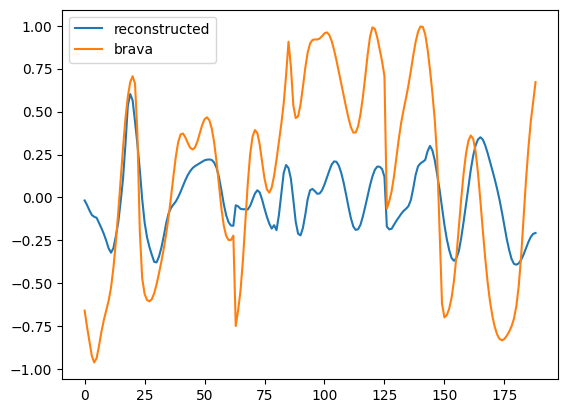

In [44]:
plt.plot(data_reconstructed[16], label="reconstructed")
plt.plot(extracted_trio_sr[16],label="brava")
plt.legend()

generating in directory ./quadratic_synthetic\...
(25, 63, 3)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


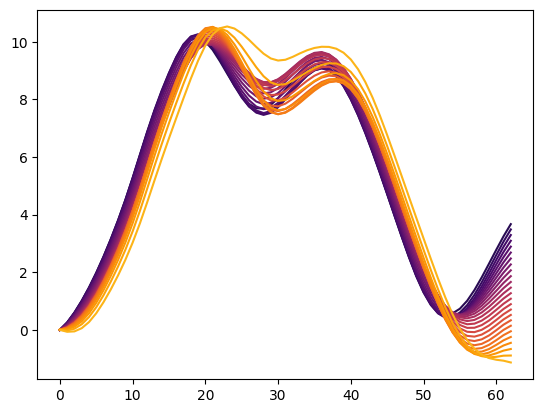

In [45]:
from myvtk.General import mkdir

quadratic_synthetic_dir = mkdir("./","quadratic_synthetic")

import matplotlib
from scipy.integrate import cumtrapz

cmap = matplotlib.cm.get_cmap("inferno")

synthetic = np.stack([x_test, y_fit]).T
synthetic_reconstructed = linear_regression.predict(synthetic)

synthetic_recovered = synthetic_reconstructed * std + mean


syn_recoverd_3d = []
for i in range(synthetic_recovered.shape[0]):
    syn_recoverd_3d.append(np.stack([synthetic_recovered[i,:63], 
                                    synthetic_recovered[i,63:63*2], 
                                    synthetic_recovered[i,63*2:63*3]]).T)
syn_recoverd_3d = np.array(syn_recoverd_3d)
print (syn_recoverd_3d.shape)

print (np.ones(62))

scalarAttribute= [['MaximumInscribedSphereRadius', 'float', np.ones(64)]]
q0=np.zeros_like(synthetic_recovered[i,:63])
for i in range(synthetic_recovered.shape[0]):
    # plt.plot(syn_recoverd_3d[i,:,2], color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))
    # synthetic_curve = np.vstack((q0, cumtrapz(synthetic_recovered[i,:63], initial=0))) + q0
    synthetic_x = cumtrapz(synthetic_recovered[i,:63], initial=0)
    synthetic_y = cumtrapz(synthetic_recovered[i,63:63*2], initial=0)
    synthetic_z = cumtrapz(synthetic_recovered[i,63*2:63*3], initial=0)
    plt.plot(synthetic_z, color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))

    syn_recoverd_3d = np.stack([synthetic_x , 
                                synthetic_y , 
                                synthetic_z]).T



    makeVtkFile(savePath = "./quadratic_synthetic/{}.vtk".format(round(x_test[i], 3)),
                coords = syn_recoverd_3d, 
                scalarAttributes=scalarAttribute,
                fieldAttributes = [])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Synthetic length: 52.35577079502869
Synthetic length: 50.903365522211075
Synthetic length: 48.87429833457411
Synthetic length: 50.03000958434594
Synthetic length: 52.381947497005505
Brava length: 64.00325582069866


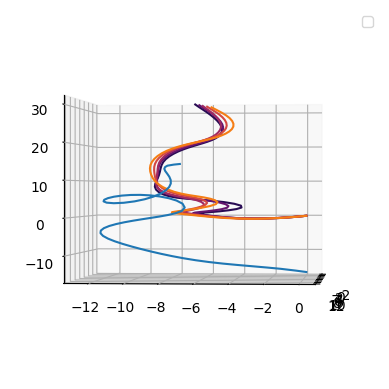

In [46]:
ax = plt.figure().add_subplot(projection='3d')


for i in  range(0, synthetic_recovered.shape[0], 5):
    # plt.plot(syn_recoverd_3d[i,:,2], color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))
    # synthetic_curve = np.vstack((q0, cumtrapz(synthetic_recovered[i,:63], initial=0))) + q0
    synthetic_x = cumtrapz(synthetic_recovered[i,:63], initial=0)
    synthetic_y = cumtrapz(synthetic_recovered[i,63:63*2], initial=0)
    synthetic_z = cumtrapz(synthetic_recovered[i,63*2:63*3], initial=0)
    # plt.plot(synthetic_x, color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))
    ax.plot(synthetic_x, synthetic_y, synthetic_z, zdir='x', color=cmap((i+5)/(synthetic_recovered.shape[0]+10)))
    synthetic_i= np.stack([synthetic_x, synthetic_y, synthetic_z]).T
    print ("Synthetic length:", measure_length(synthetic_i))

# Make legend, set axes limits and labels
ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.plot(aligned_pts[0][:,2]-aligned_pts[0][0,2],aligned_pts[0][:,0]-aligned_pts[0][0,0],aligned_pts[0][:,1])
print ("Brava length:", measure_length(aligned_pts[0]))


# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=0, azim=5, roll=0)


plt.show()

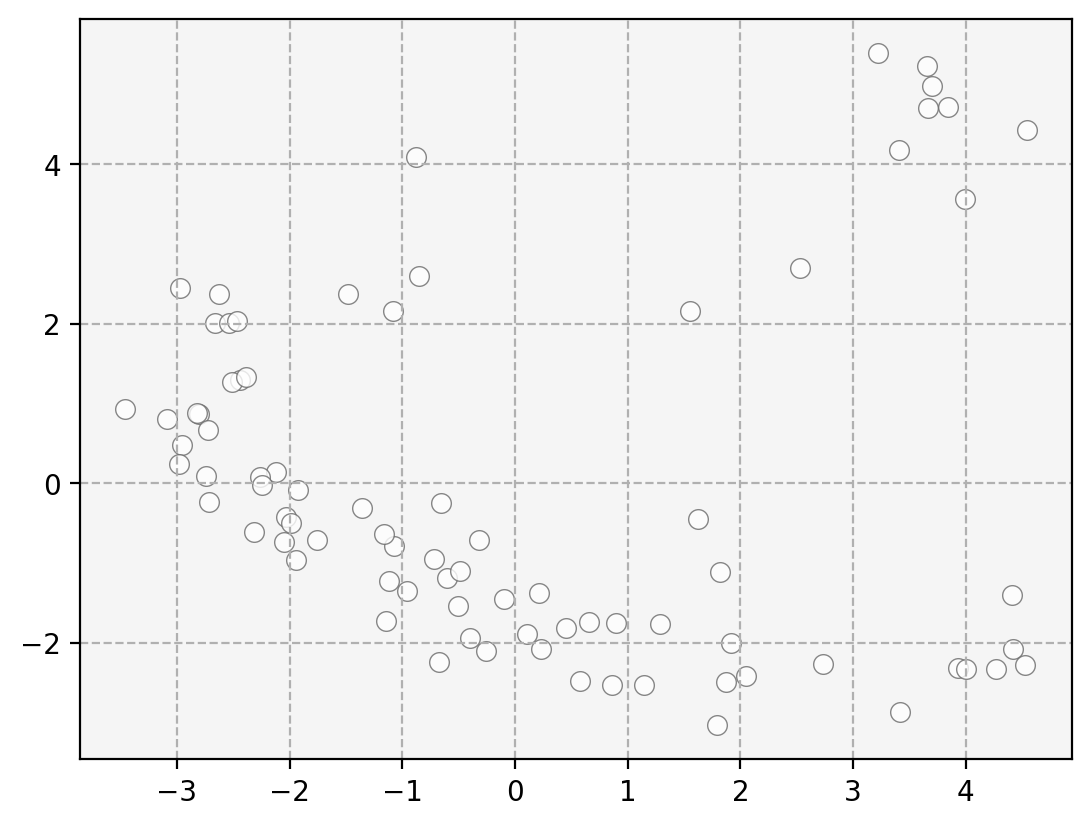

In [47]:
pca = PCA(n_components=16)
feature = pca.fit_transform(extracted_trio_sr)
reconstructed = pca.inverse_transform(feature)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

ax.scatter(feature[:,0], feature[:,1],
           s = 50,
           color = "white",
           edgecolor="dimgray",
           linewidths=0.5,
           alpha=0.8)
ax.set_facecolor("whitesmoke")
ax.grid(linestyle="--")

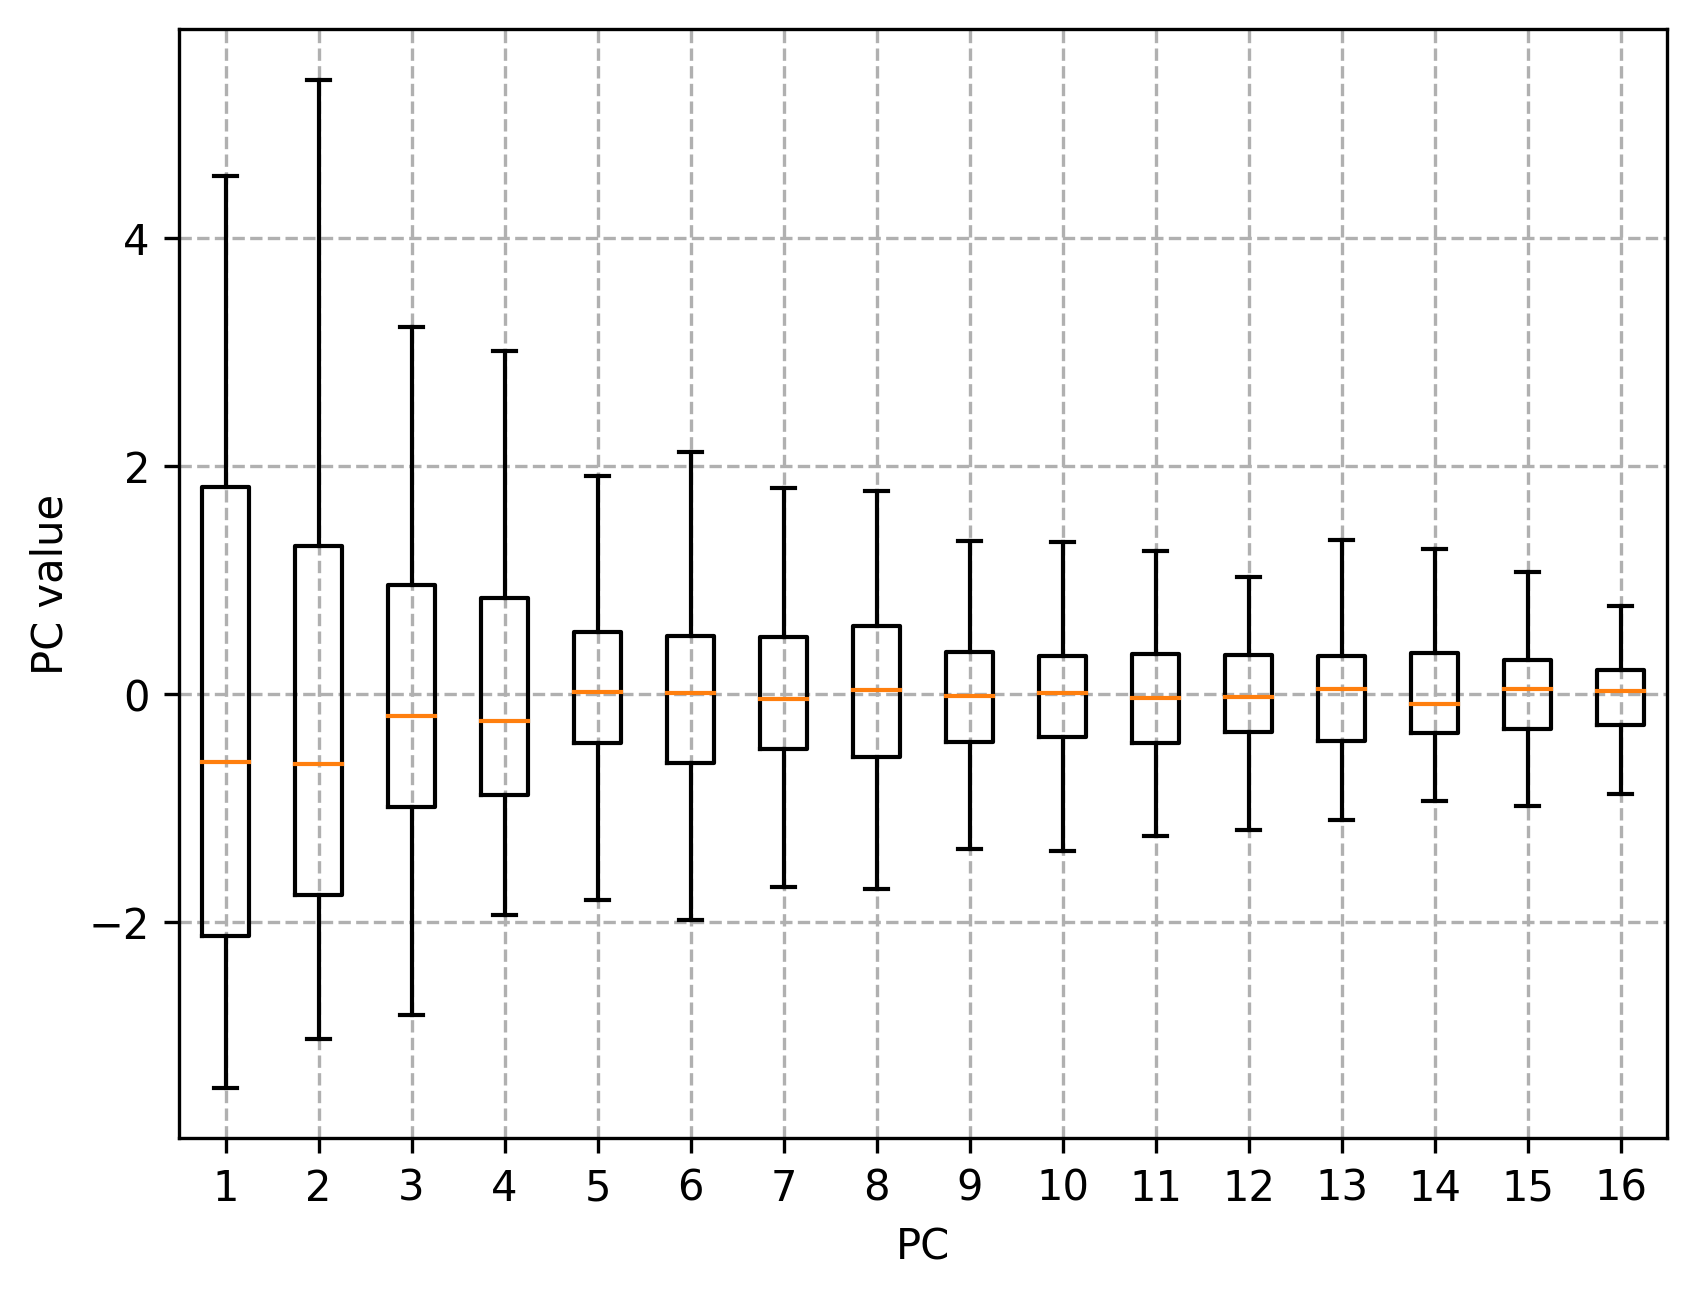

In [48]:

fig = plt.figure(dpi=300)
ax =fig.add_subplot(111)

ax.boxplot(feature,showfliers=False)

ax.set_xlabel("PC")
ax.set_ylabel("PC value")
plt.grid(linestyle="--")
plt.show()

(189,)


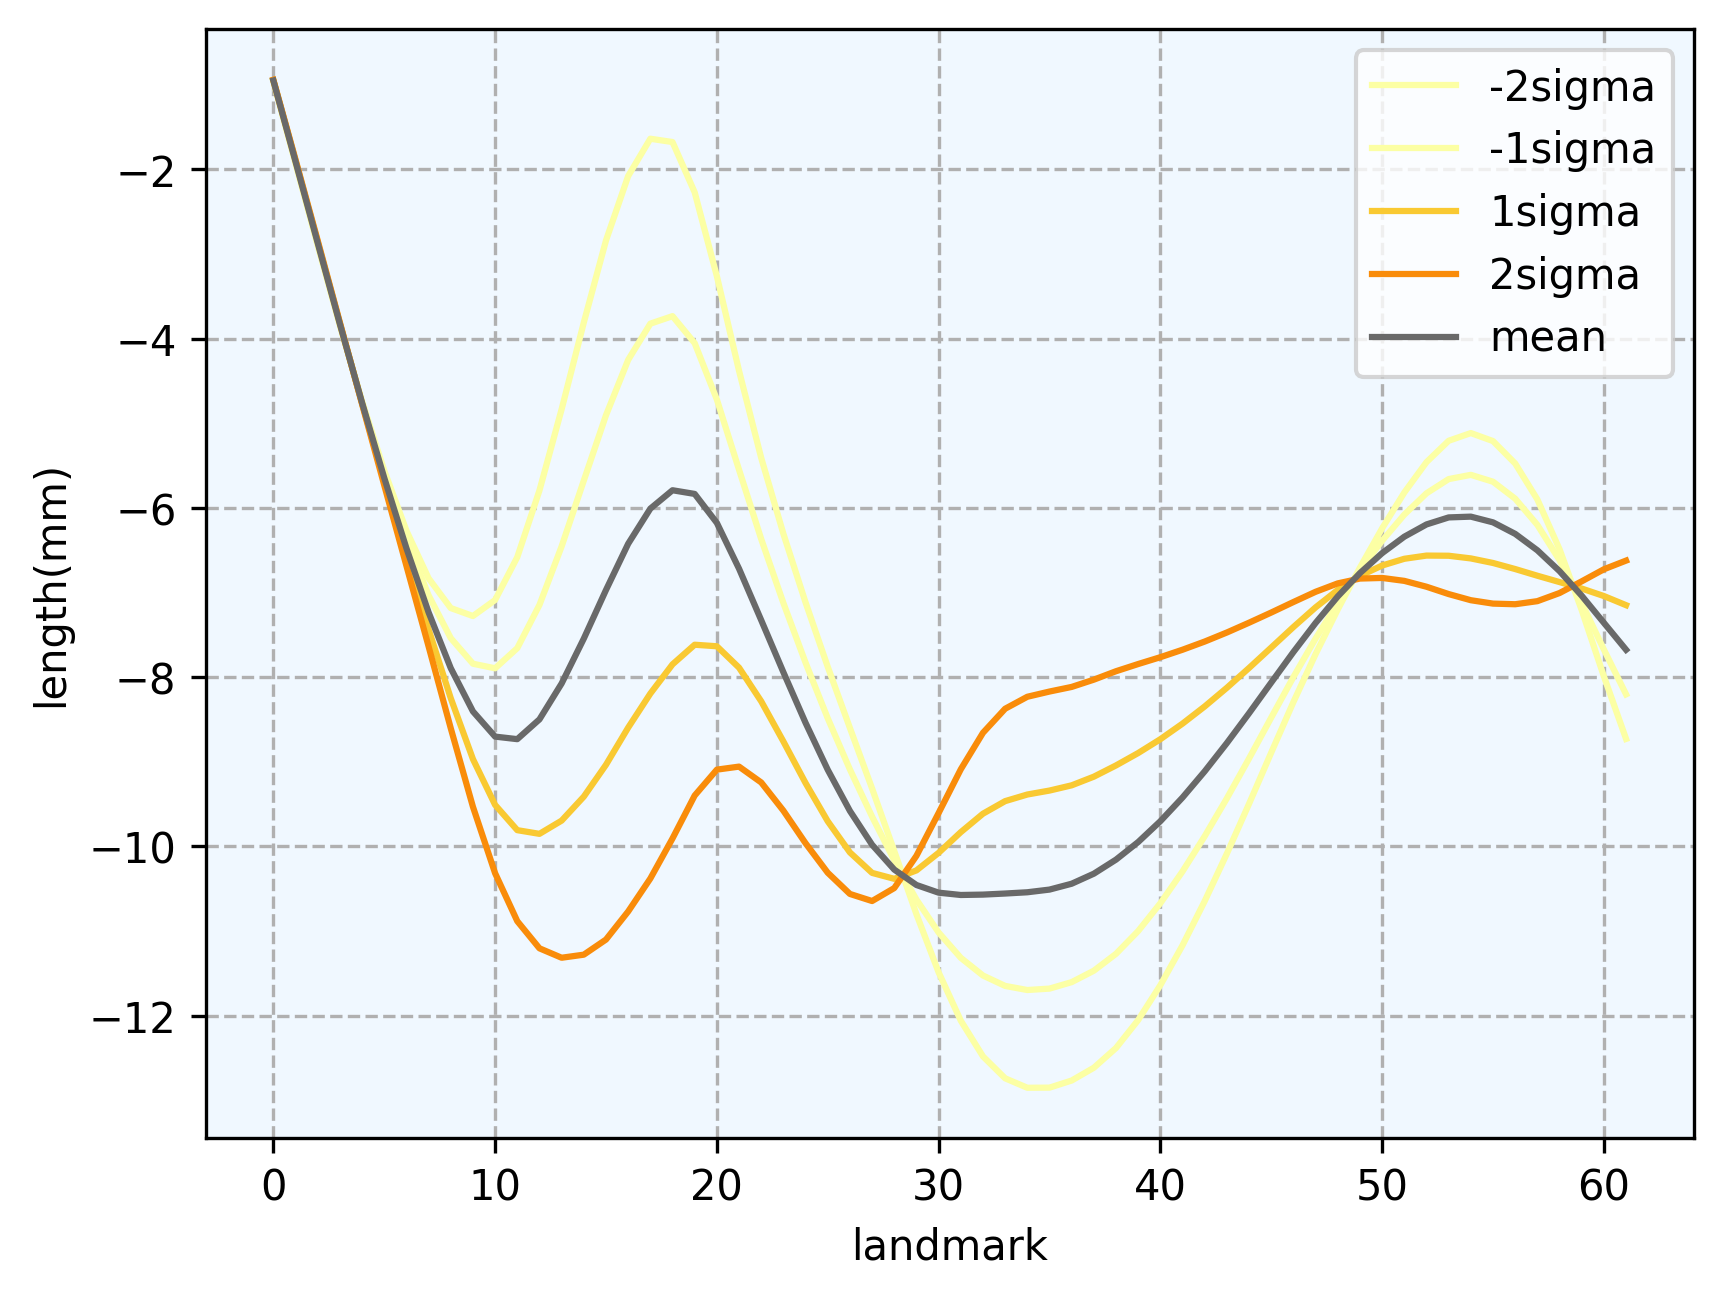

In [49]:
import matplotlib
def inverse(feature):
    feature = np.array(feature)
    # print(feature)
    resultinverse = pca.inverse_transform(feature)
    # result: (192,)
    shape = np.zeros(resultinverse.shape[0]).reshape(resultinverse.shape[0]//3, 3)
    shape[:,0] =resultinverse[:63]
    shape[:,1] =resultinverse[63:126]
    shape[:,2] =resultinverse[126:]
    return shape

def inverse_recover(shape):
    # print (np.std(aligned_pts,axis=0).shape)
    # print (np.mean(aligned_pts,axis=0).shape)
    recover_shape = shape*np.column_stack((std[:63], 
                                           std[63:126], 
                                           std[126:]))+np.column_stack((mean[:63], 
                                                                        mean[63:126], 
                                                                        mean[126:]))
    return recover_shape
print (std.shape)

cmap = matplotlib.cm.get_cmap("inferno_r")
fig = plt.figure(dpi=300)
ax =fig.add_subplot(111)

pcs_std = []
pcs_mean  = []
for i in range(len(pca.components_)):
    pcs_std.append(np.std(feature[:,i]))
    pcs_mean.append(np.mean(feature[:,i]))

pcs_mean = np.array(pcs_mean)  
pcs_std = np.array(pcs_std)
# print (pcs_std.shape,pcs_mean)



mean_shape = inverse_recover((inverse(pcs_mean)))
np.save("./SRVR_meanshape.npy",mean_shape)
for j in range(len([-2,-1,1,2])):
    i = [-2,-1,1,2][j]
    std1_shape = inverse_recover(inverse(pcs_mean+i*pcs_std))
    # ax.plot(std1_shape[:,0],label="{}sigma".format(i), color=cmap(i/8))
    ax.plot(cumtrapz(std1_shape[:,0]),label="{}sigma".format(i), color=cmap(i/8))

# ax.plot(mean_shape[:,0],label="mean",color="dimgray")
ax.plot(cumtrapz(mean_shape[:,0]),label="mean",color="dimgray")
ax.set_xlabel("landmark")
ax.set_ylabel("length(mm)")
ax.set_facecolor("aliceblue")

plt.legend()
plt.grid(linestyle="--")
plt.show()